In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [6]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [2]:
class AE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        input_size = 28 * 28
        self.encoder = self._encoder(input_size, latent_dim)
        self.decoder = self._decoder(input_size, latent_dim)

    def _encoder(self, input_size, latent_dim):
        encoder = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(int(input_size/2), latent_dim),
            nn.ReLU()
        )
        return encoder

    def _decoder(self, input_size, latent_dim):
        decoder = nn.Sequential(
            nn.Linear(latent_dim, int(input_size/2)),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(int(input_size/2), input_size),
            nn.Sigmoid()
        )
        return decoder

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

In [3]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [4]:
def plot_manifold(autoencoder, x, y, filesave=None):
    x = x.view(-1, 28*28)
    x_latent = autoencoder.encode(x).detach().numpy()
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=x_latent[:, 0],
                    y=x_latent[:, 1],
                    hue=y,
                    palette=sns.color_palette("hsv", 10), 
                    legend='full')
    
    plt.title('Latent space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    if filesave is not None:
        plt.savefig(filesave)
    plt.show()

In [88]:
def plot_rescontruction_and_actual_images(model, x, y):
    num_images = len(np.unique(y))
    unique_labels = np.unique(y)
    plt.figure(figsize=(20, 6))
    
    x_show = []
    y_show = []
    for img, label in zip(x, y):
        if label not in y_show:
            y_show.append(label)
            x_show.append(img)
        if len(y_show) == num_images:
            break

    x_show_reshape = np.concatenate(x_show).reshape(-1, 28*28)
    x_reconstructed = model(torch.tensor(x_show_reshape)).detach().numpy()

    for i in range(num_images):
        ax = plt.subplot(2, num_images, i+1)
        plt.imshow(x_show[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(x_reconstructed[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(round(mean_squared_error(x_show[i].flatten(), x_reconstructed[i].flatten()), 4))
    plt.show()

In [19]:
def train(model, X, X_val, lr=0.1, optimizer='Adam', epochs=20, batch_size=128, loss='BCELoss', shuffle=True):
    optimizer = getattr(optim, optimizer)(model.parameters(), lr=lr)

    try:
        loss_fn = getattr(nn, loss)()
    except:
        loss_fn = loss

    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, threshold=1e-3, verbose=True)
    es = EarlyStopping(patience=5, 
                   delta=0, 
                   mode='min', 
                   verbose=True
                  )
    mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle)
    mnist_validationset = DataLoader(X_val, batch_size=batch_size, shuffle=shuffle)

    for epoch in range(1, epochs+1):
        train_loss = 0.0
        batch_num = 0
        model.train()

        for images in mnist_trainset:
            images = images.view(images.size(0), 28*28)

            optimizer.zero_grad()
            y_hat = model(images)

            loss = loss_fn(y_hat, images)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()/len(images):.6f}', end='\r')
            batch_num += images.size(0)

        # validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for i, image in enumerate(mnist_validationset):
                recon_image = model(image)
                val_loss = loss_fn(recon_image, image)
                total_val_loss += val_loss
        avg_val_loss = total_val_loss / (i+1)

        lr_scheduler.step(avg_val_loss)
        es(avg_val_loss)
        if es.early_stop:
            break

        train_loss = train_loss / len(X.data)
        print(f'Epoch: {epoch} [{batch_num}/{len(X)}] - Loss: {train_loss:.6f}, validdation_loss: {avg_val_loss}, lr:{optimizer.param_groups[0]["lr"]}')

In [20]:
exclude_class_0 = True

transform = transforms.ToTensor()
mnist_train = MNIST('data/', download=True, train=True, transform=transform)
mnist_test = MNIST('data/', download=True, train=False, transform=transform)

x_train = mnist_train.data[mnist_train.targets != 0]
x_test = mnist_test.data[mnist_test.targets != 0]
y_train = mnist_train.targets[mnist_train.targets != 0]
y_test = mnist_test.targets[mnist_test.targets != 0]

x_test_all = mnist_test.data.type(torch.FloatTensor) / 255.
y_test_all = mnist_test.targets

x_train = x_train.type(torch.FloatTensor) / 255.
x_test = x_test.type(torch.FloatTensor) / 255.

In [21]:
ae = AE(2)
ae.apply(init_weights)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=392, out_features=2, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=392, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=392, out_features=784, bias=True)
    (4): Sigmoid()
  )
)

In [22]:
train(ae, x_train.view(-1, 28*28), x_test.view(-1, 28*28), epochs=50, lr=0.01, optimizer='Adam', loss="MSELoss", batch_size=512)

[EarlyStopping] (Update) Best Score: 0.05818
Epoch: 1 [54077/54077] - Loss: 0.000132, validdation_loss: 0.05818409472703934, lr:0.01
[EarlyStopping] (Update) Best Score: 0.05477
Epoch: 2 [54077/54077] - Loss: 0.000114, validdation_loss: 0.05477095767855644, lr:0.01
[EarlyStopping] (Update) Best Score: 0.04996
Epoch: 3 [54077/54077] - Loss: 0.000106, validdation_loss: 0.049964554607868195, lr:0.01
[EarlyStopping] (Update) Best Score: 0.04881
Epoch: 4 [54077/54077] - Loss: 0.000103, validdation_loss: 0.04880724474787712, lr:0.01
[EarlyStopping] (Update) Best Score: 0.04833
Epoch: 5 [54077/54077] - Loss: 0.000101, validdation_loss: 0.04833419620990753, lr:0.01
[EarlyStopping] (Update) Best Score: 0.04805
Epoch: 6 [54077/54077] - Loss: 0.000101, validdation_loss: 0.04804703965783119, lr:0.01
[EarlyStopping] (Update) Best Score: 0.04780
Epoch: 7 [54077/54077] - Loss: 0.000100, validdation_loss: 0.04780280962586403, lr:0.01
[EarlyStopping] (Update) Best Score: 0.04772
Epoch: 8 [54077/54077] 

/tmp/ipykernel_1925/831857225.py:6: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(x=x_latent[:, 0],


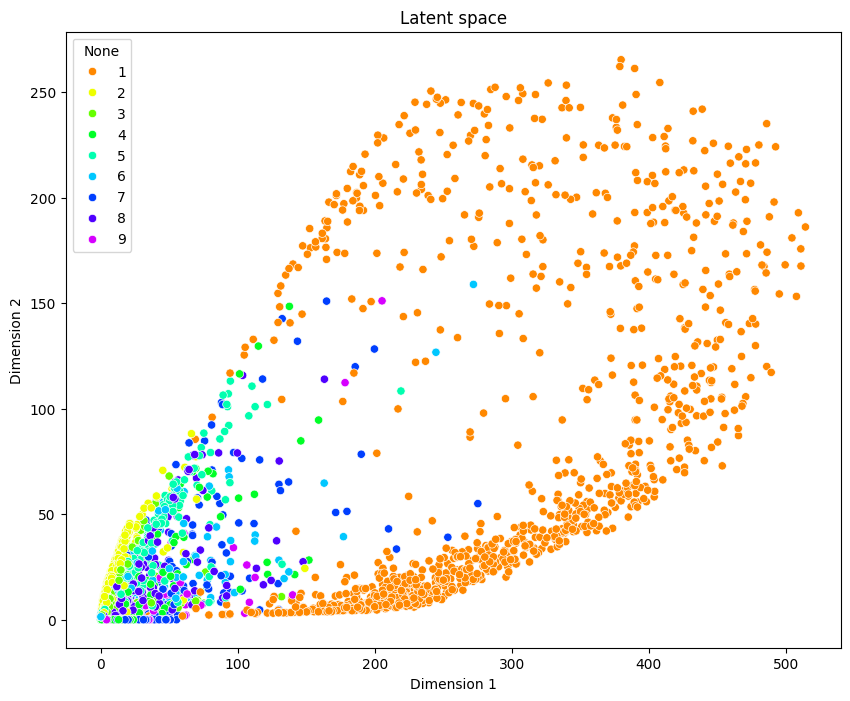

In [74]:
plot_manifold(ae, x_test.view(-1, 28*28), y_test)

In [75]:
mse_classes = dict()
reconstructed_images = ae(mnist_test.data.view(-1, 28*28).type(torch.FloatTensor)/255.)
for i in range(10):
    mse_classes[i] = 0.
    
    # get index
    indexs = y_test_all[y_test_all == i]
    x = x_test_all[indexs].view(-1, 28*28)
    recon_x = ae(x)
    mse_classes[i] = nn.MSELoss()(recon_x, x).item()
    
for key, value in avg_mse_classes.items():
    print('Averge mse of class {}: {}'.format(key, value))

Averge mse of class 0: 0.08557405897929352
Averge mse of class 1: 0.01458193252708287
Averge mse of class 2: 0.05595038550393295
Averge mse of class 3: 0.05275769975073267
Averge mse of class 4: 0.048109504045224356
Averge mse of class 5: 0.05428179489624073
Averge mse of class 6: 0.05438783273124185
Averge mse of class 7: 0.04198293090736356
Averge mse of class 8: 0.0537564715225196
Averge mse of class 9: 0.03916483992900851


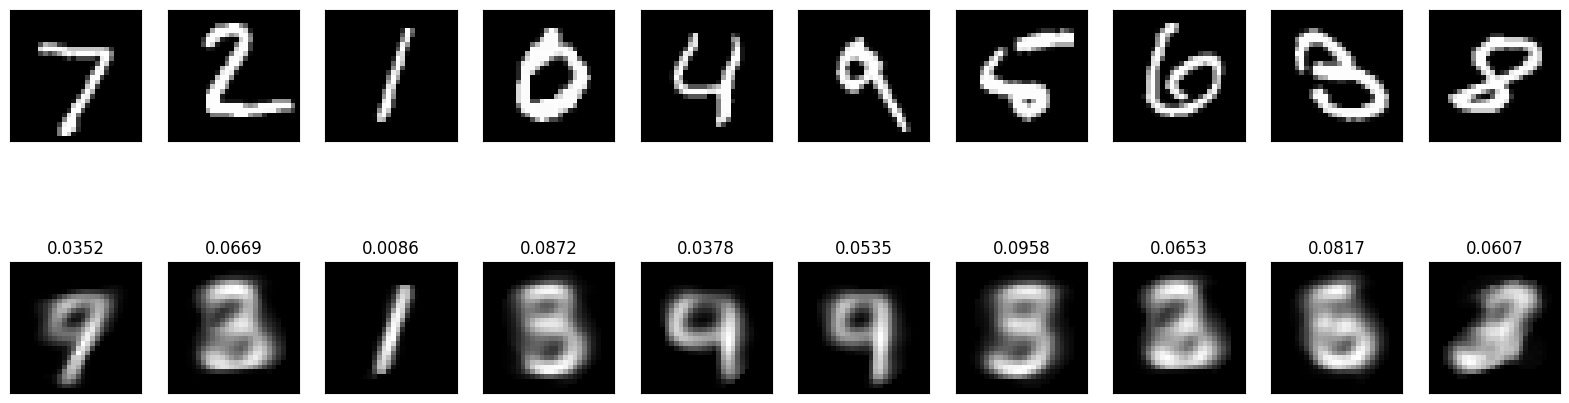

In [91]:
plot_rescontruction_and_actual_images(ae, x_test_all.data.view(-1, 28*28), y_test_all)